# Morals of knowledge transfer

I present 3 techniques, accompanied by 3 moral analogies.

Disclaimer: the morals are totally unrelated from the phenomena. (This doesn't make them untrue tho.)

In [1]:
!pip install -r requirements.txt

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Input, Softmax
from tensorflow.keras import Model

from plot import plot_predictions, plot_images, plot_image
from IPython.core.display import SVG

np.random.seed(420)
tf.random.set_seed(420)

# The dataset

## MNIST

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [4]:
def select_digits(digits=range(10)):
    x_train_selected = x_train[np.in1d(y_train, digits)]
    y_train_selected = y_train[np.in1d(y_train, digits)]
    return (x_train_selected, y_train_selected), (x_test, y_test)

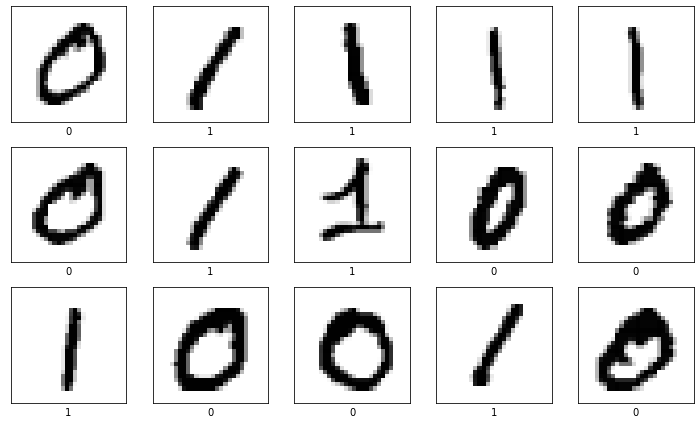

In [6]:
(x_train_selected, y_train_selected), (x_test, y_test) = select_digits([0, 1])

plot_images(x_train_selected, y_train_selected)

# The models

## Teacher

In [7]:
def teacher():
    return tf.keras.models.Sequential([
        Conv2D(32, 3, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10)
    ])

![](teacher.jpg)

## Student

In [12]:
def student():
    return tf.keras.models.Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(10)
    ])

![](student.jpg)

# Knowledge distillaton

## Train teacher

In [8]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()

teacher_model = teacher()
teacher_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_selected, 
    y_train_selected, 
    test_size=0.3, 
    random_state=42)
teacher_model.fit(x_tr, 
          y_tr, 
          epochs=20, 
          validation_data=(x_val, y_val),
          callbacks=[tf.keras.callbacks.EarlyStopping()])

test_loss, teacher_test_acc = teacher_model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print('\nTest accuracy:', teacher_test_acc)

Epoch 1/20
1313/1313 [==============================] - 21s 16ms/step - loss: 0.1948 - accuracy: 0.9416 - val_loss: 0.0801 - val_accuracy: 0.9754
Epoch 2/20
1313/1313 [==============================] - 18s 14ms/step - loss: 0.0679 - accuracy: 0.9789 - val_loss: 0.0655 - val_accuracy: 0.9809
Epoch 3/20
1313/1313 [==============================] - 20s 15ms/step - loss: 0.0400 - accuracy: 0.9872 - val_loss: 0.0652 - val_accuracy: 0.9818
Epoch 4/20
1313/1313 [==============================] - 20s 16ms/step - loss: 0.0278 - accuracy: 0.9904 - val_loss: 0.0610 - val_accuracy: 0.9830
Epoch 5/20
1313/1313 [==============================] - 20s 15ms/step - loss: 0.0213 - accuracy: 0.9925 - val_loss: 0.0616 - val_accuracy: 0.9844
313/313 - 1s - loss: 0.0515 - accuracy: 0.9844

Test accuracy: 0.9843999743461609


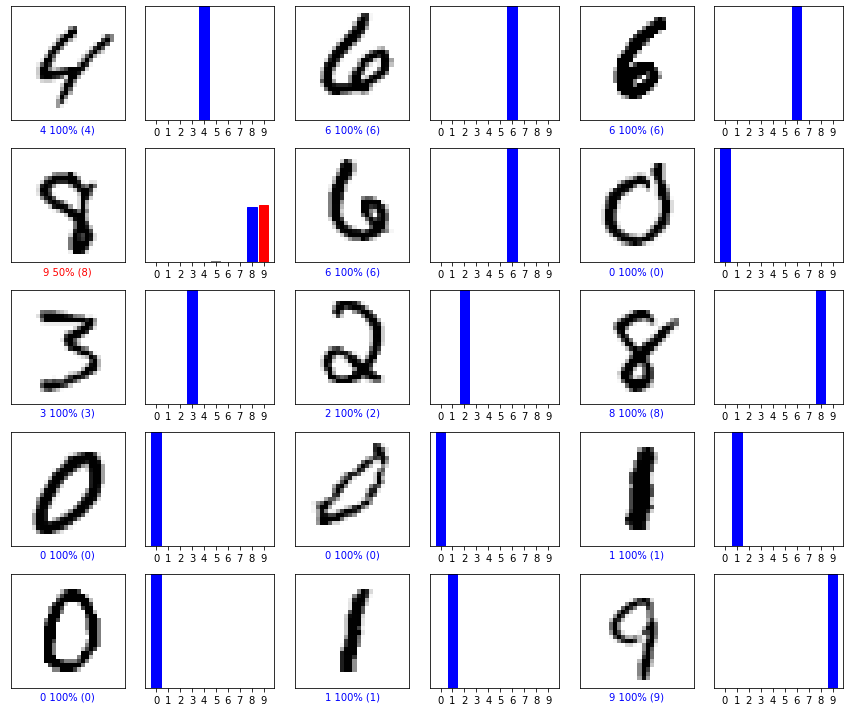

In [10]:
teacher_model_prob = tf.keras.Sequential([teacher_model, Softmax()])
predictions = teacher_model_prob.predict(x_test_selected)
plot_predictions(x_test_selected, y_test_selected, predictions)

## Train autodidact student

In [13]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()

student_model = student()
student_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_selected, 
    y_train_selected, 
    test_size=0.3, 
    random_state=42)
student_model.fit(x_tr, 
                  y_tr, 
                  epochs=20, 
                  validation_data=(x_val, y_val),
                  callbacks=[tf.keras.callbacks.EarlyStopping()])

test_loss, auto_test_acc = student_model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print('\nTest accuracy:', auto_test_acc)

Epoch 1/20
1313/1313 [==============================] - 2s 2ms/step - loss: 0.5292 - accuracy: 0.8624 - val_loss: 0.3402 - val_accuracy: 0.9094
Epoch 2/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.3217 - accuracy: 0.9105 - val_loss: 0.3057 - val_accuracy: 0.9166
Epoch 3/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.2952 - accuracy: 0.9168 - val_loss: 0.2887 - val_accuracy: 0.9209
Epoch 4/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.2819 - accuracy: 0.9211 - val_loss: 0.2837 - val_accuracy: 0.9224
Epoch 5/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.2729 - accuracy: 0.9247 - val_loss: 0.2851 - val_accuracy: 0.9217
313/313 - 0s - loss: 0.2738 - accuracy: 0.9236

Test accuracy: 0.9236000180244446


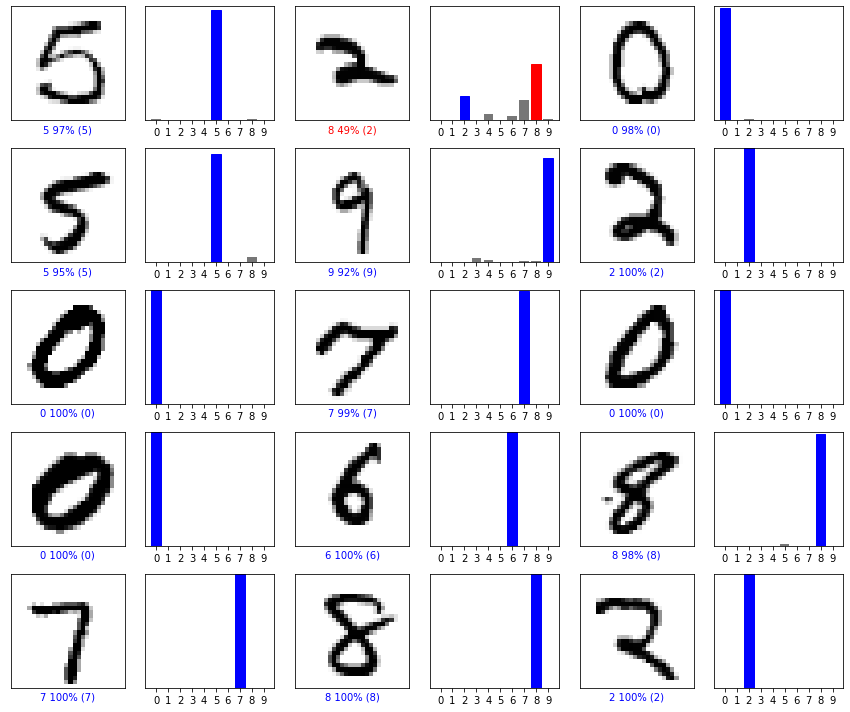

In [14]:
student_model_prob = tf.keras.Sequential([student_model, Softmax()])
predictions = student_model_prob.predict(x_test_selected)

plot_predictions(x_test_selected, y_test_selected, predictions)

## Episode: Softmax with temperature

\begin{equation*}
softmax(\mathbf{z})_c = \frac{e^{z_c}}{\sum_{d=1}^K e^{z_d}} \quad \text{for} \; c = 1 
\cdots K
\end{equation*}

\begin{equation*}
softmax(\mathbf{z}, T)_c = \frac{e^{\frac{z_c}{T}}}{\sum_{d=1}^K e^{\frac{z_d}{T}}} \quad \text{for} \; c = 1 \cdots K 
\end{equation*}

In [15]:
class TemperatureScale(tf.keras.layers.Layer):
    def __init__(self, t=1, **kwargs):
        super(TemperatureScale, self).__init__(**kwargs)
        self.t = t
    
    def call(self, inputs):
        return tf.divide(inputs, self.t)

In [16]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()

teacher_model_prob = tf.keras.Sequential([teacher_model, 
                                          TemperatureScale(t=1),
                                          Softmax()])
teacher_predictions_1 = teacher_model_prob.predict(tf.expand_dims(x_train_selected[0], axis=0))

teacher_model_prob = tf.keras.Sequential([teacher_model, 
                                          TemperatureScale(t=5),
                                          Softmax()])
teacher_predictions_5 = teacher_model_prob.predict(tf.expand_dims(x_train_selected[0], axis=0))

teacher_model_prob = tf.keras.Sequential([teacher_model, 
                                          TemperatureScale(t=10),
                                          Softmax()])
teacher_predictions_10 = teacher_model_prob.predict(tf.expand_dims(x_train_selected[0], axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



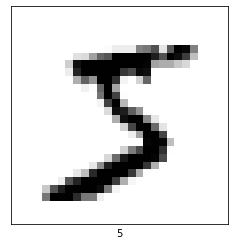

In [17]:
plot_image(x_train_selected[0], y_train_selected[0])
plt.show()

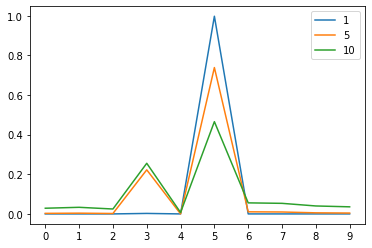

In [18]:
plt.plot(teacher_predictions_1[0])
plt.plot(teacher_predictions_5[0])
plt.plot(teacher_predictions_10[0])
plt.legend([1, 5, 10])
plt.xticks(range(10))
plt.show()

## Distill the dark knowledge

In [19]:
T = 1.2
teacher_model_prob = tf.keras.Sequential([teacher_model, TemperatureScale(t=T), Softmax()])
teacher_predictions = teacher_model_prob.predict(x_train_selected)

In [20]:
student_model = student()
student_model_T = tf.keras.Sequential([student_model, TemperatureScale(t=T)])
student_model_T.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                      metrics=['accuracy'])

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_selected, 
    teacher_predictions, 
    test_size=0.3, 
    random_state=42)
student_model_T.fit(x_tr,
                  y_tr, 
                  epochs=20, 
                  validation_data=(x_val, y_val), 
                  callbacks=[tf.keras.callbacks.EarlyStopping()])

Epoch 1/20
1313/1313 [==============================] - 2s 2ms/step - loss: 0.5605 - accuracy: 0.8589 - val_loss: 0.3385 - val_accuracy: 0.9103
Epoch 2/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.3302 - accuracy: 0.9083 - val_loss: 0.2953 - val_accuracy: 0.9211
Epoch 3/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.3008 - accuracy: 0.9165 - val_loss: 0.2766 - val_accuracy: 0.9225
Epoch 4/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.2863 - accuracy: 0.9205 - val_loss: 0.2702 - val_accuracy: 0.9250
Epoch 5/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.2768 - accuracy: 0.9238 - val_loss: 0.2687 - val_accuracy: 0.9247
Epoch 6/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.2705 - accuracy: 0.9255 - val_loss: 0.2619 - val_accuracy: 0.9272
Epoch 7/20
1313/1313 [==============================] - 2s 1ms/step - loss: 0.2659 - accuracy: 0.9263 - val_loss: 0.2611 - val_accuracy:

In [21]:
metrics = student_model_T.evaluate(x_test_selected,  
                                 tf.one_hot(y_test_selected, depth=10),
                                 verbose=2)
test_loss, test_acc = metrics
print(f'\nDistilled test accuracy: {test_acc:.4f} (vs autodidact: {auto_test_acc:.4f}, teacher: {teacher_test_acc:.4f})')

313/313 - 0s - loss: 0.2696 - accuracy: 0.9241

Distilled test accuracy: 0.9241 (vs autodidact: 0.9236, teacher: 0.9844)


In [22]:
student_model_prob = tf.keras.Sequential([student_model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)

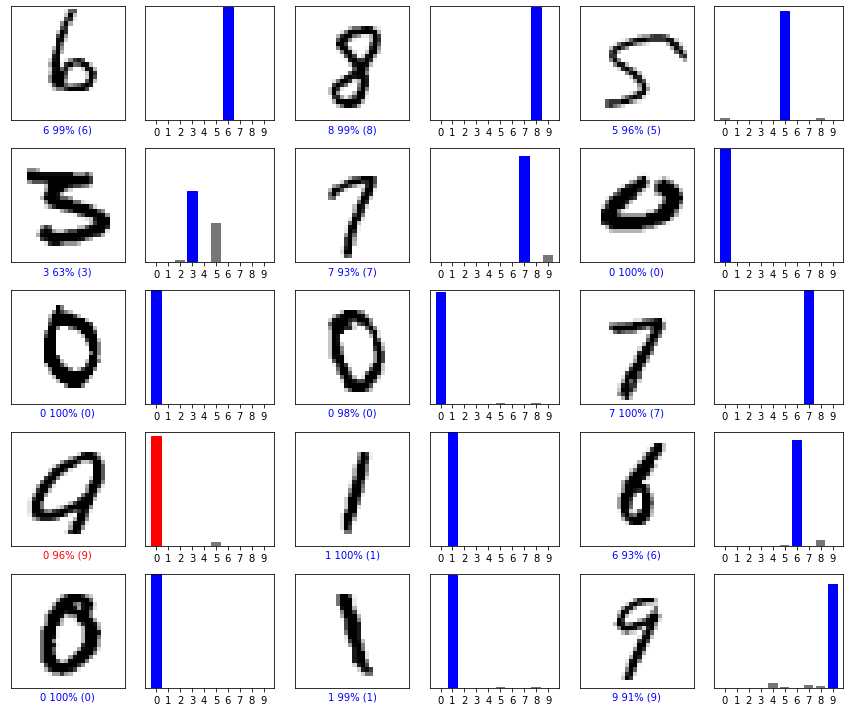

In [23]:
plot_predictions(x_test_selected, y_test_selected, predictions)

In [24]:
print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96       980
          1       0.97      0.98      0.98      1135
          2       0.91      0.89      0.90      1032
          3       0.91      0.90      0.91      1010
          4       0.93      0.93      0.93       982
          5       0.92      0.86      0.89       892
          6       0.95      0.94      0.94       958
          7       0.92      0.92      0.92      1028
          8       0.87      0.90      0.88       974
          9       0.91      0.90      0.91      1009

avg / total       0.92      0.92      0.92     10000



## Moral #1:

Those who can, do; those who can't, teach. But it's ok.

# Training on limited data

In [25]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits([0, 1, 2, 5])

student_model = student()
student_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

student_model.fit(x_train_selected, 
          y_train_selected, 
          epochs=20, 
          validation_split=0.3, 
          callbacks=[tf.keras.callbacks.EarlyStopping()])

test_loss, auto_test_acc = student_model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print('\nTest accuracy:', auto_test_acc)

Epoch 1/20
526/526 [==============================] - 1s 2ms/step - loss: 0.3298 - accuracy: 0.9173 - val_loss: 0.1479 - val_accuracy: 0.9586
Epoch 2/20
526/526 [==============================] - 1s 2ms/step - loss: 0.1319 - accuracy: 0.9633 - val_loss: 0.1125 - val_accuracy: 0.9673
Epoch 3/20
526/526 [==============================] - 1s 2ms/step - loss: 0.1086 - accuracy: 0.9686 - val_loss: 0.0996 - val_accuracy: 0.9692
Epoch 4/20
526/526 [==============================] - 1s 2ms/step - loss: 0.0974 - accuracy: 0.9714 - val_loss: 0.0965 - val_accuracy: 0.9719
Epoch 5/20
526/526 [==============================] - 1s 2ms/step - loss: 0.0906 - accuracy: 0.9730 - val_loss: 0.0891 - val_accuracy: 0.9724
Epoch 6/20
526/526 [==============================] - 1s 1ms/step - loss: 0.0849 - accuracy: 0.9749 - val_loss: 0.0864 - val_accuracy: 0.9732
Epoch 7/20
526/526 [==============================] - 1s 2ms/step - loss: 0.0808 - accuracy: 0.9761 - val_loss: 0.0854 - val_accuracy: 0.9742
Epoch 

In [27]:
student_model_prob = tf.keras.Sequential([student_model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)

print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

             precision    recall  f1-score   support

          0       0.68      0.99      0.81       980
          1       0.61      0.99      0.75      1135
          2       0.32      0.97      0.48      1032
          3       0.00      0.00      0.00      1010
          4       0.00      0.00      0.00       982
          5       0.24      0.96      0.38       892
          6       0.00      0.00      0.00       958
          7       0.00      0.00      0.00      1028
          8       0.00      0.00      0.00       974
          9       0.00      0.00      0.00      1009

avg / total       0.19      0.40      0.25     10000



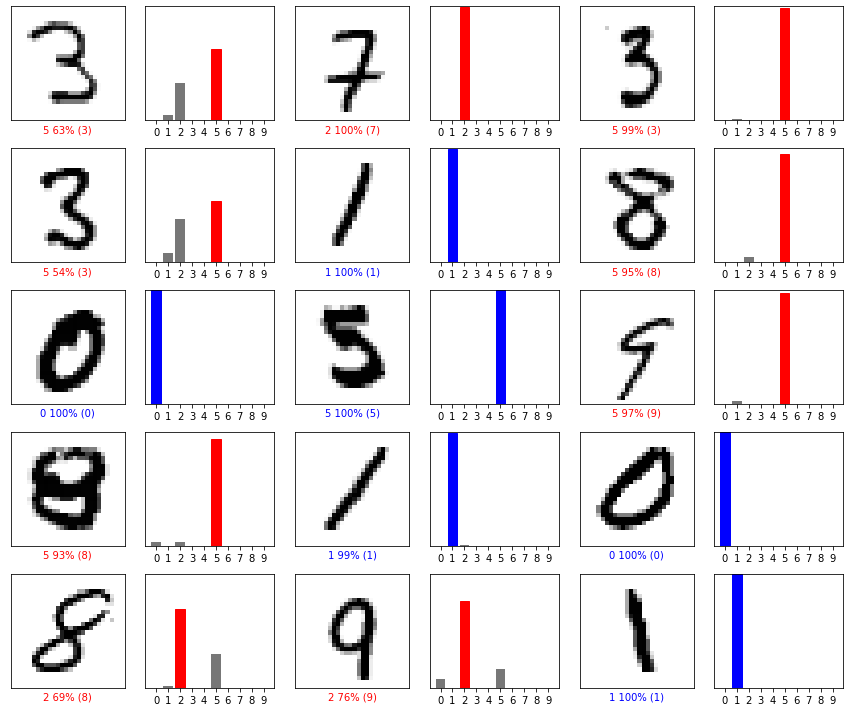

In [28]:
plot_predictions(x_test_selected, y_test_selected, predictions)

## Distillation on limited data

In [29]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits([0, 1, 2, 5])
T=100
teacher_model_prob = tf.keras.Sequential([teacher_model, TemperatureScale(t=T), Softmax()])
teacher_predictions = teacher_model_prob.predict(x_train_selected)

In [30]:
student_model = student()
student_model_T = tf.keras.Sequential([student_model, TemperatureScale(t=T)])
student_model_T.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

student_model_T.fit(x_train_selected, 
          teacher_predictions, 
          epochs=20, 
          validation_split=0.3, 
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
                 verbose=0)

test_loss, test_acc = student_model_T.evaluate(x_test_selected,  
                                               tf.one_hot(y_test_selected, depth=10), 
                                               verbose=2)
print(f'\nTest accuracy: {test_acc:.4f} (vs {auto_test_acc:.4f})')

313/313 - 0s - loss: 2.2064 - accuracy: 0.5317

Test accuracy: 0.5317 (vs 0.3950)


In [31]:
student_model_prob = tf.keras.Sequential([student_model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)

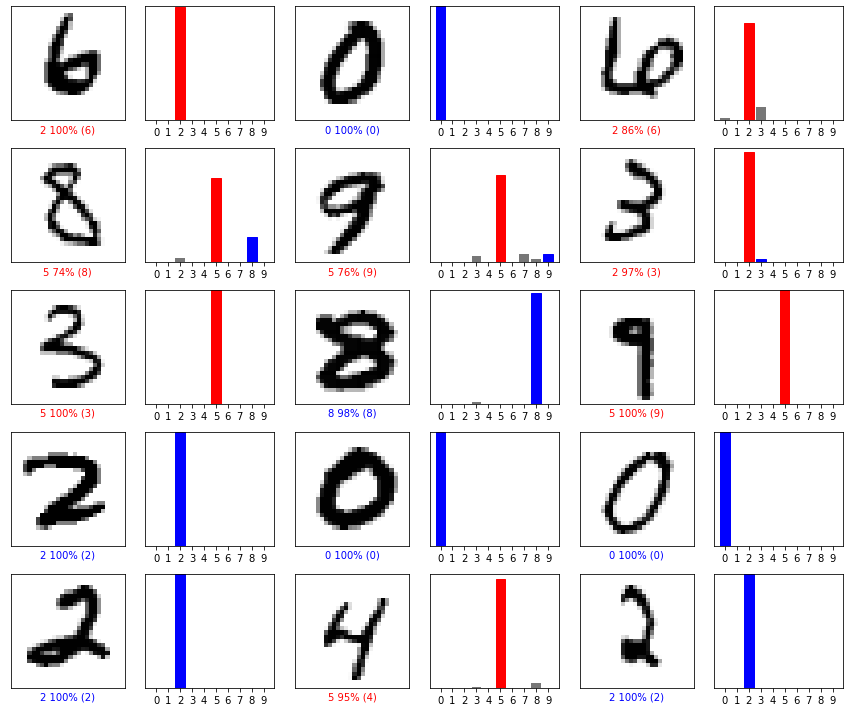

In [32]:
plot_predictions(x_test_selected, y_test_selected, predictions)

In [33]:
print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

             precision    recall  f1-score   support

          0       0.84      0.97      0.90       980
          1       0.73      0.98      0.83      1135
          2       0.49      0.90      0.63      1032
          3       0.64      0.38      0.48      1010
          4       0.80      0.14      0.24       982
          5       0.25      0.92      0.39       892
          6       0.93      0.21      0.34       958
          7       0.85      0.44      0.58      1028
          8       0.53      0.29      0.37       974
          9       0.45      0.04      0.07      1009

avg / total       0.65      0.53      0.49     10000



## Moral #2:

An experienced teacher might teach you more than the subject itself.

# Federated learning

In [34]:
def average_weights(models):
    w = models[0].get_weights()
    for i in range(1, len(models)):
        w_i = models[i].get_weights()
        for j in range(len(w)):
            w[j] += w_i[j]

    for j in range(len(w)):
        w[j] /= len(models)

    for m in models:
        m.set_weights(w)

In [35]:
models = []
for i in range(3):
    model = student()

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    models.append(model)

In [36]:
datasets = [
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8, 9],
]

In [37]:
rounds = 50
local_epochs = 1
for r in range(rounds):
    print(f'round {r}')
    for m, d in zip(models, datasets):
        (x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits(d)

        m.fit(x_train_selected, 
              y_train_selected, 
              epochs=local_epochs,
             verbose=0)
    test_loss, auto_test_acc = models[0].evaluate(x_test_selected,  y_test_selected, verbose=2)
    average_weights(models)
    test_loss, auto_test_acc = models[0].evaluate(x_test_selected,  y_test_selected, verbose=2)

round 0
313/313 - 0s - loss: 4.3120 - accuracy: 0.3077
313/313 - 0s - loss: 1.4526 - accuracy: 0.7460
round 1
313/313 - 0s - loss: 3.3779 - accuracy: 0.3083
313/313 - 0s - loss: 1.0795 - accuracy: 0.8010
round 2
313/313 - 0s - loss: 2.8448 - accuracy: 0.3100
313/313 - 0s - loss: 0.8891 - accuracy: 0.8219
round 3
313/313 - 0s - loss: 2.4807 - accuracy: 0.3292
313/313 - 0s - loss: 0.7776 - accuracy: 0.8321
round 4
313/313 - 0s - loss: 2.2217 - accuracy: 0.3610
313/313 - 0s - loss: 0.7048 - accuracy: 0.8408
round 5
313/313 - 0s - loss: 2.0292 - accuracy: 0.3924
313/313 - 0s - loss: 0.6532 - accuracy: 0.8469
round 6
313/313 - 0s - loss: 1.8804 - accuracy: 0.4234
313/313 - 0s - loss: 0.6145 - accuracy: 0.8518
round 7
313/313 - 0s - loss: 1.7616 - accuracy: 0.4490
313/313 - 0s - loss: 0.5842 - accuracy: 0.8566
round 8
313/313 - 0s - loss: 1.6643 - accuracy: 0.4672
313/313 - 0s - loss: 0.5599 - accuracy: 0.8612
round 9
313/313 - 0s - loss: 1.5829 - accuracy: 0.4855
313/313 - 0s - loss: 0.5398

In [38]:
model = models[0]

In [39]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()
test_loss, auto_test_acc = model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print(f'\nTest accuracy:', auto_test_acc)

313/313 - 0s - loss: 0.3652 - accuracy: 0.8994

Test accuracy: 0.899399995803833


In [40]:
student_model_prob = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()
print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95       980
          1       0.94      0.98      0.96      1135
          2       0.91      0.84      0.87      1032
          3       0.87      0.91      0.89      1010
          4       0.87      0.92      0.89       982
          5       0.86      0.85      0.85       892
          6       0.91      0.93      0.92       958
          7       0.90      0.92      0.91      1028
          8       0.88      0.80      0.84       974
          9       0.89      0.86      0.87      1009

avg / total       0.90      0.90      0.90     10000



## Moral #3:

Where we're going, we don't need teachers!

# Stuff to read

#### Knowledge distillation
https://arxiv.org/abs/1503.02531
#### Federated learning
https://arxiv.org/abs/1602.05629

#### Tensorflow
https://www.tensorflow.org/tutorials